# Cancel Culture - Classification Modeling Notebook

---

**Post-Cleaning Modeling Notebook**

---

# 📦 Imports

In [1]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## SKLearn
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                                AdaBoostClassifier,GradientBoostingClassifier 
from sklearn import set_config
set_config(display='diagram')

## Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 50)

## Personal functions
from bmc_functions import classification as clf

In [2]:
%load_ext autoreload
%autoreload 2

# 👓 Reading the DataFrames

In [3]:
city_full = pd.read_pickle('./data/reservation_city_unfiltered.pickle',
                           compression = 'gzip')
city_full.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_day
city_old,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40060,0,6,2015,July,27,1,0,2,1,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,0.00,0,0,Check-Out,2015-07-03,2015-07-01,Wednesday
40061,1,88,2015,July,27,1,0,4,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.50,0,1,Canceled,2015-07-01,2015-07-01,Wednesday
40062,1,65,2015,July,27,1,0,4,1,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,68.00,0,1,Canceled,2015-04-30,2015-07-01,Wednesday
40063,1,92,2015,July,27,1,2,4,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.50,0,2,Canceled,2015-06-23,2015-07-01,Wednesday
40064,1,100,2015,July,27,2,0,2,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.50,0,1,Canceled,2015-04-02,2015-07-02,Thursday


In [4]:
city_fltrd = pd.read_pickle('./data/reservation_city_filtered.pickle',
                            compression = 'gzip')
city_fltrd.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_day
city_filtered,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40060,0,6,2015,July,27,1,0,2,1,0.00,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,0,Transient,0.00,0,0,Check-Out,2015-07-03,2015-07-01,Wednesday
40061,1,88,2015,July,27,1,0,4,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.50,0,1,Canceled,2015-07-01,2015-07-01,Wednesday
40062,1,65,2015,July,27,1,0,4,1,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,68.00,0,1,Canceled,2015-04-30,2015-07-01,Wednesday
40063,1,92,2015,July,27,1,2,4,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.50,0,2,Canceled,2015-06-23,2015-07-01,Wednesday
40064,1,100,2015,July,27,2,0,2,2,0.00,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,0,Transient,76.50,0,1,Canceled,2015-04-02,2015-07-02,Thursday


In [5]:
resort_full = pd.read_pickle('./data/reservation_resort_unfiltered.pickle',
                             compression = 'gzip')
resort_full.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_day
resort_old,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,999,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,Wednesday
1,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,999,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,Wednesday
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,999,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,Wednesday


In [6]:
resort_fltrd = pd.read_pickle('./data/reservation_resort_filtered.pickle',
                              compression = 'gzip')
resort_fltrd.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_day
resort_filtered,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,999,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
3,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
4,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,Wednesday
5,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,Wednesday
6,0,0,2015,July,27,1,0,2,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,999,0,Transient,107.00,0,0,Check-Out,2015-07-03,2015-07-01,Wednesday


# Train/Test Split

In [7]:
## Identifying target
target= 'is_canceled'

In [8]:
X = city_full.drop(columns = target).copy()
y = city_full[target].copy()

In [9]:
X.shape[0] == y.shape[0]

True

In [10]:
## Splitting - stratify to maintain class balance b/t X_train/_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state=42, 
                                                    stratify=y)

In [11]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes('number').columns.to_list()
num_cols

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [12]:
## Specifying numeric columns for preprocessing
cat_cols = X_train.select_dtypes(include='object').columns.to_list()
cat_cols

['arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'customer_type',
 'reservation_status',
 'arrival_day']

In [13]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding

### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore',
                                                 sparse=False))])

num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

## Instantiating the ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['lead_time', 'arrival_date_year',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'da...,
                                  'adr', 'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['arrival_date_month', 'meal', 'country',
                                  'market_segment', 'distribution_channel',
                                  'reserved_room_type', 'assigned_room_type',
                                  'deposit_type', 'agent', 'customer_type',
                                  'reservation_status', 'arrival_day'])])

In [14]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

final_cols

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'country_ABW',
 'country_AGO',
 'country_AIA',
 'country_ALB',
 'country_AND',
 'country_ARE',
 'country_ARG',
 'country_ARM',
 'country_ASM',
 'country_ATA',
 'country_ATF',
 'country_AUS',
 'country_AUT',


In [15]:
## Transform the data via the ColumnTransformer preprocessor

X_train_tf = preprocessor.transform(X_train)
X_train_tf_df = pd.DataFrame(X_train_tf, columns=final_cols, index=X_train.index)

X_test_tf = preprocessor.transform(X_test)
X_test_tf_df = pd.DataFrame(X_test_tf, columns=final_cols, index=X_test.index)

display(X_train_tf_df.head(5),X_test_tf_df.head(5))

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MNE,country_MOZ,country_MRT,country_MUS,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_PRY,country_QAT,country_ROU,country_RUS,country_SAU,country_SEN,country_SGP,country_SLE,country_SLV,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZWE,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_K,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,agent_1,agent_10,agent_103,agent_104,agent_106,agent_11,agent_111,agent_112,agent_117,agent_118,agent_119,agent_12,agent_121,agent_122,agent_128,agent_129,agent_13,agent_132,agent_133,agent_134,agent_138,agent_14,agent_141,agent_147,agent_148,agent_15,agent_150,agent_151,agent_152,agent_153,agent_154,agent_155,agent_157,agent_158,agent_159,agent_16,agent_162,agent_167,agent_168,agent_17,agent_170,agent_171,agent_173,agent_174,agent_177,agent_179,agent_180,agent_182,agent_187,agent_19,agent_191,agent_192,agent_193,agent_195,agent_196,agent_2,agent_20,agent_205,agent_21,agent_210,agent_211,agent_213,agent_214,agent_215,agent_216,agent_219,agent_22,agent_220,agent_227,agent_229,

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MNE,country_MOZ,country_MRT,country_MUS,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_POL,country_PRI,country_PRT,country_PRY,country_QAT,country_ROU,country_RUS,country_SAU,country_SEN,country_SGP,country_SLE,country_SLV,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZWE,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_K,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,agent_1,agent_10,agent_103,agent_104,agent_106,agent_11,agent_111,agent_112,agent_117,agent_118,agent_119,agent_12,agent_121,agent_122,agent_128,agent_129,agent_13,agent_132,agent_133,agent_134,agent_138,agent_14,agent_141,agent_147,agent_148,agent_15,agent_150,agent_151,agent_152,agent_153,agent_154,agent_155,agent_157,agent_158,agent_159,agent_16,agent_162,agent_167,agent_168,agent_17,agent_170,agent_171,agent_173,agent_174,agent_177,agent_179,agent_180,agent_182,agent_187,agent_19,agent_191,agent_192,agent_193,agent_195,agent_196,agent_2,agent_20,agent_205,agent_21,agent_210,agent_211,agent_213,agent_214,agent_215,agent_216,agent_219,agent_22,agent_220,agent_227,agent_229,

# 📊 **Baseline Model**


|-------------------------------- Classification Metrics -----------------------------------|

The training score is: 0.4996275154810857
The testing score is: 0.5023832436600213
	- The training score is smaller by 0.00 points.


Training data log loss: 16.81
Testing data log loss: 16.70



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.58      0.59      0.59     11557
           1       0.42      0.42      0.42      8276

    accuracy                           0.52     19833
   macro avg       0.50      0.50      0.50     19833
weighted avg       0.52      0.52      0.52     19833



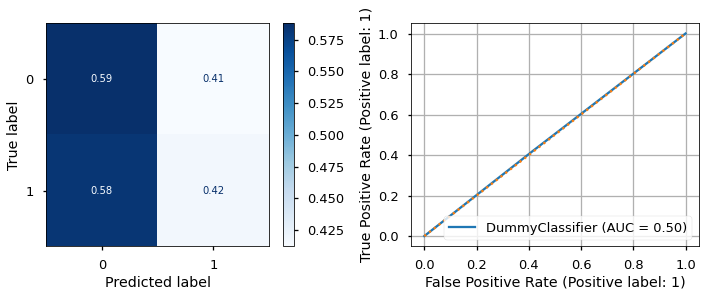


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.58      0.58      0.58     34671
           1       0.42      0.42      0.42     24826

    accuracy                           0.51     59497
   macro avg       0.50      0.50      0.50     59497
weighted avg       0.51      0.51      0.51     59497



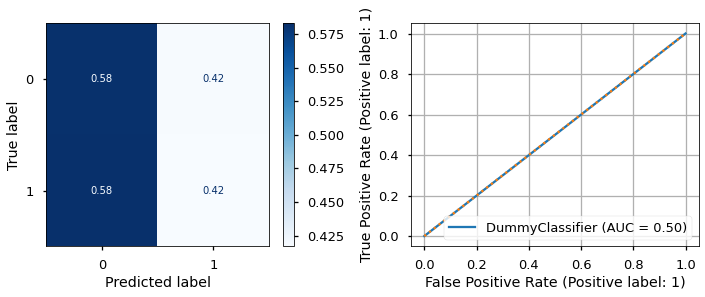

In [19]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_tf_df, y_train)

clf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'balanced accuracy')

# `sklearn.metrics.get_scorer()`

In [22]:
## Making test results for testing
y_hat_train = base.predict(X_train_tf_df)
y_hat_test = base.predict(X_test_tf_df)

In [23]:
## Inspecting results of get scorer
score_function = metrics.get_scorer('recall_macro')
score_function

make_scorer(recall_score, pos_label=None, average=macro)

In [24]:
## testing score function
score_function(base, y_train, y_hat_train)

1.0

In [25]:
## testing score function
score_function(base, y_test, y_hat_test)

1.0

---

Not sure why getting 1.0 results when using score function. Must be error.

Create DF from clf_rpt; add blank col (then .T to turn into row); then remove dup values from precision/recall for accuracy/

---

In [38]:
## Getting clf rpt as dict -> df
cr_df = pd.DataFrame(metrics.classification_report(y_test, y_hat_test,
                                                   output_dict=True))
cr_df

,0,1,accuracy,macro avg,weighted avg
precision,0.58,0.42,0.52,0.50,0.52
recall,0.59,0.42,0.52,0.50,0.52
f1-score,0.59,0.42,0.52,0.50,0.52
support,"11,557.00","8,276.00",0.52,"19,833.00","19,833.00"


In [41]:
cr_df = cr_df.applymap(lambda x: round(x, 2))
# round(cr_df, 2)
cr_df

,0,1,accuracy,macro avg,weighted avg
precision,0.58,0.42,0.52,0.50,0.52
recall,0.59,0.42,0.52,0.50,0.52
f1-score,0.59,0.42,0.52,0.50,0.52
support,"11,557.00","8,276.00",0.52,"19,833.00","19,833.00"


In [42]:
## adding blank col b/t 1, "accuracy"
cr_df.insert(2,column=" ", value=" ")
cr_df

,0,1,,accuracy,macro avg,weighted avg
precision,0.58,0.42,,0.52,0.50,0.52
recall,0.59,0.42,,0.52,0.50,0.52
f1-score,0.59,0.42,,0.52,0.50,0.52
support,"11,557.00","8,276.00",,0.52,"19,833.00","19,833.00"


In [43]:
# Transposing df
cr_df = cr_df.T
cr_df

,precision,recall,f1-score,support
0,0.58,0.59,0.59,"11,557.00"
1,0.42,0.42,0.42,"8,276.00"
,,,,
accuracy,0.52,0.52,0.52,0.52
macro avg,0.50,0.50,0.50,"19,833.00"
weighted avg,0.52,0.52,0.52,"19,833.00"


In [44]:
cr_df['precision'][0]

0.58

In [48]:
## Converting 'accuracy' values to strings to replace values w/ blank strings
for value in range(len(cr_df.loc['accuracy':,])):
    cr_df.loc['accuracy'][value] = str(cr_df.loc['accuracy'][value])

cr_df

,precision,recall,f1-score,support
0,0.58,0.59,0.59,"11,557.00"
1,0.42,0.42,0.42,"8,276.00"
,,,,
accuracy,0.52,0.52,0.52,0.52
macro avg,0.50,0.50,0.50,"19,833.00"
weighted avg,0.52,0.52,0.52,"19,833.00"


In [47]:
cr_df.loc['accuracy'][2:4] = pd.to_numeric(cr_df.loc['accuracy'][2:4])
cr_df.loc['accuracy'][2:4]

f1-score   0.52
support    0.52
Name: accuracy, dtype: object

In [ ]:
# ## Replacing dupe values in accuracy to match report function
# ## Need to convert dtype to string, then replace w/ a string w/ one space
cr_df.loc['accuracy',['precision', 'recall']] = cr_df.loc['accuracy',['precision', 'recall']] = ' '
cr_df.loc['accuracy']

In [ ]:
cr_df.loc['accuracy','support'] = cr_df.loc['macro avg','support']
cr_df.loc['accuracy']

In [ ]:
print(metrics.classification_report(y_test, y_hat_test))

In [ ]:
cr_df

# Focus on Model!

In [ ]:
## LogReg Model

clf = LogisticRegression(tol = 1e-3, C = 10, penalty = "l1", solver = 'saga', 
                         max_iter=500, class_weight='balanced', n_jobs=-1,
                         random_state = 42)

clf.fit(X_train_tf_df, y_train)

cf.evaluate_classification(clf, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced accuracy')